# Compare baseline SplitNet with SIREN

### Get models

In [29]:
from train_pipeline import train

import os
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from hydra.utils import instantiate
from omegaconf import OmegaConf


def load_cfg(overrides=(), config_name='config'):
    # with initialize_config_dir(config_dir="/app/notebooks/draft_02/conf"):
    with initialize(version_base=None, config_path="./conf"):
        cfg = compose(config_name=config_name, overrides=list(overrides))
        return cfg

from IPython.display import clear_output

cfg = load_cfg(config_name='08_splitnet_first_step')

cfg.logging.experiment_name='splitnet_m=10__baseline'

# print(OmegaConf.to_yaml(cfg))

splitnet_m10 = instantiate(cfg.model, out_features=1)


# train(cfg)

In [13]:
cfg = load_cfg(config_name='08_splitnet_first_step__siren')

cfg.logging.experiment_name='siren_baseline'

siren = instantiate(cfg.model, out_features=1)
# print(OmegaConf.to_yaml(cfg))
# train(cfg)

In [14]:
cfg = load_cfg(config_name='08_splitnet_first_step')

cfg.logging.experiment_name='splitnet_m=1__baseline'
cfg.model.model_configs[0].m = 1.

splitnet_m1 = instantiate(cfg.model, out_features=1)

# print(OmegaConf.to_yaml(cfg))
# train(cfg)

### Do plots

In [25]:
from spellbook.splitnet import plot_distributions, U
from spellbook.splitnet import *


In [26]:
def plot_distributions(data, 
                       title='sample titles', 
                       autosize=False, 
                       facet_col_wrap=4,
                       showlegend=False,
                       width=1000,
                       height=600,
                       xlim=None,
                       ylim=None):
    for k, v in data.items():
        print(k, tensor2str(v))
    data = {k: to_np(v) for k, v in data.items()}

    df = pd.DataFrame(data)

    # Melt the dataframe to a long format for easier plotting
    df_melted = df.melt(var_name="act", value_name="value")

    # Plot histograms using Plotly Express
    fig = px.histogram(
        df_melted,
        x="value",
        color="act",
        facet_col="act",
        facet_col_wrap=facet_col_wrap,
        histnorm="probability density",
        title=title,
    )

    fig.update_layout(
        autosize=autosize,
        width=width,
        height=height,
        showlegend=showlegend,
    )
    
    # Update x and y axis ranges if provided
    if xlim is not None:
        fig.update_xaxes(range=xlim)
    if ylim is not None:
        fig.update_yaxes(range=ylim)

    fig.show()


In [16]:
x = U(3_000, 2)

In [17]:
siren_activations = siren.forward_with_activations(x)
siren_activations = {v for k,v in siren_activations.items() if '_act' in k}

In [18]:
siren_activations

{tensor[3000, 1] x∈[-0.125, 0.021] μ=-0.053 σ=0.020 grad AddmmBackward0,
 tensor[3000, 256] n=768000 x∈[-1.000, 1.000] μ=-0.021 σ=0.701 grad SinBackward0,
 tensor[3000, 256] n=768000 x∈[-1.000, 1.000] μ=-0.022 σ=0.715 grad SinBackward0,
 tensor[3000, 256] n=768000 x∈[-1.000, 1.000] μ=-0.059 σ=0.719 grad SinBackward0,
 tensor[3000, 256] n=768000 x∈[-1.000, 1.000] μ=0.004 σ=0.705 grad SinBackward0}

In [20]:
x_enc = splitnet_m10.encoding(x)
h, intermediate_acts = splitnet_m10.networks[0].forward_with_activations(x_enc)

splitnet_m10_activations = [h[0] for h in  (intermediate_acts)]
splitnet_m10_activations

[tensor[3000, 128] n=384000 x∈[-5.391, 5.121] μ=-0.005 σ=0.642 grad MulBackward0,
 tensor[3000, 128] n=384000 x∈[-5.591, 4.839] μ=-0.005 σ=0.560 grad MulBackward0,
 tensor[3000, 1] x∈[-0.343, 0.237] μ=-0.010 σ=0.049 grad MulBackward0]

In [21]:
x_enc = splitnet_m1.encoding(x)
h, intermediate_acts = splitnet_m1.networks[0].forward_with_activations(x_enc)

splitnet_m1_activations = [h[0] for h in  (intermediate_acts)]
splitnet_m1_activations

[tensor[3000, 128] n=384000 x∈[-0.563, 0.576] μ=3.248e-05 σ=0.064 grad MulBackward0,
 tensor[3000, 128] n=384000 x∈[-0.018, 0.015] μ=-1.470e-05 σ=0.002 grad MulBackward0,
 tensor[3000, 1] x∈[-0.001, -0.001] μ=-0.001 σ=3.836e-05 grad MulBackward0]

In [22]:
import pandas as pd

datas = {}

for i, (siren_a, splitnet_m1_a, splitnet_m10_a) in enumerate(zip(siren_activations, splitnet_m1_activations, splitnet_m10_activations)):
    # data = {: , f'SplitNet acts {i}': splitnet_a}
    datas[f'SIREN Layer {i}'] = siren_a
    # break
    datas[f'SplitNet m1 Layer {i}'] = splitnet_m1_a
    datas[f'SplitNet m10 Layer {i}'] = splitnet_m10_a
    # datas.append(data)
    # plot_distributions(data, title=f'Layer {i}')

SIREN Layer 0 (3000, 256) in [-1.000, 1.000] μ=0.004 σ=0.705
SplitNet m1 Layer 0 (3000, 128) in [-0.563, 0.576] μ=0.000 σ=0.064
SplitNet m10 Layer 0 (3000, 128) in [-5.391, 5.121] μ=-0.005 σ=0.642
SIREN Layer 1 (3000, 256) in [-1.000, 1.000] μ=-0.059 σ=0.719
SplitNet m1 Layer 1 (3000, 128) in [-0.018, 0.015] μ=-0.000 σ=0.002
SplitNet m10 Layer 1 (3000, 128) in [-5.591, 4.839] μ=-0.005 σ=0.560
SIREN Layer 2 (3000, 1) in [-0.125, 0.021] μ=-0.053 σ=0.020
SplitNet m1 Layer 2 (3000, 1) in [-0.001, -0.001] μ=-0.001 σ=0.000
SplitNet m10 Layer 2 (3000, 1) in [-0.343, 0.237] μ=-0.010 σ=0.049


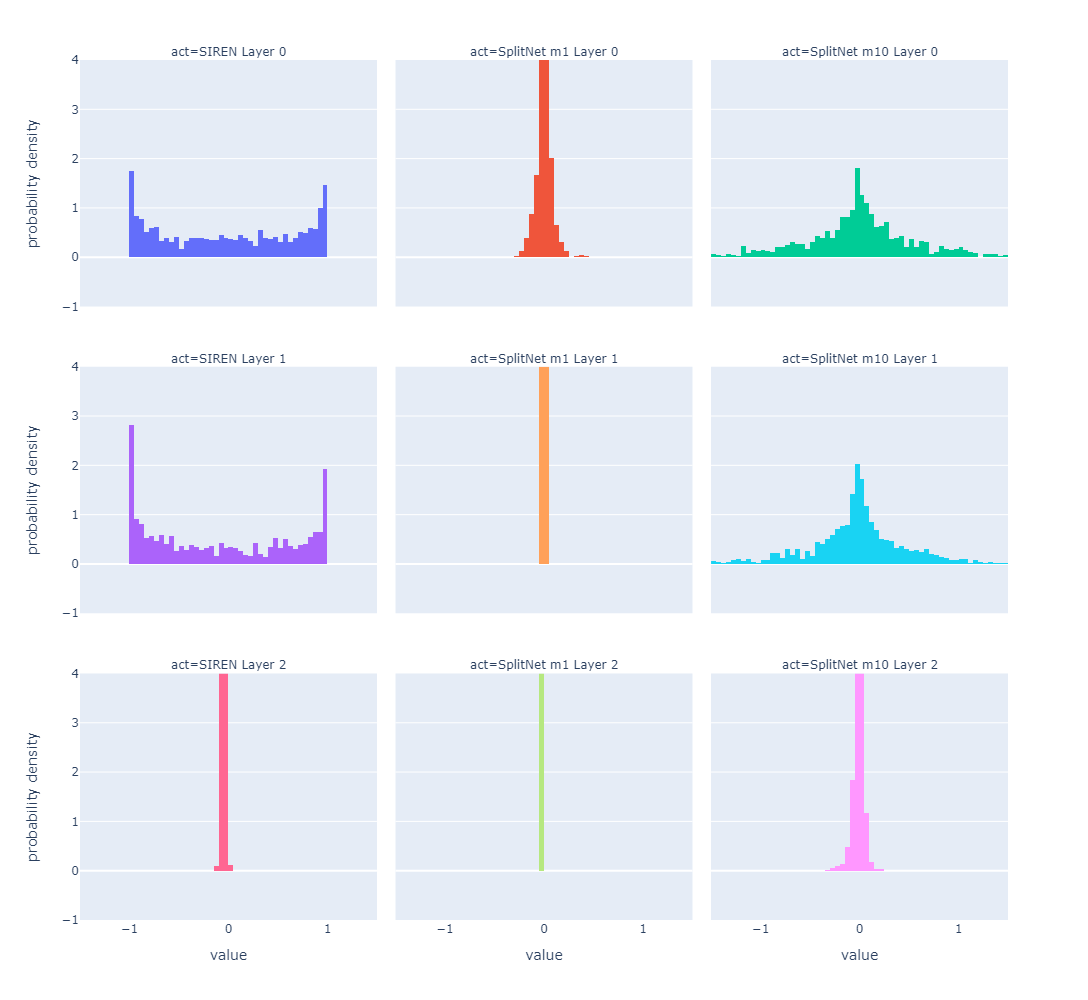

In [28]:
plot_distributions(datas, facet_col_wrap=3, autosize=False, width=1000, height=1000, title=None, xlim=(-1.5, 1.5))

### Backlog

In [2]:
from train_pipeline import *

In [3]:
cfg["model"]

{'_target_': 'spellbook.siren.model.Siren', 'in_features': 2, 'out_features': 'none', 'hidden_features': 128, 'hidden_layers': 3, 'init_c': 6, 'first_layer_init_c': 1, 'outermost_linear': True}

In [4]:
siren = instantiate(cfg.model, out_features=1)
total_params = count_parameters(siren)

+---------------------+------------+
|       Modules       | Parameters |
+---------------------+------------+
| net.0.linear.weight |    256     |
|  net.0.linear.bias  |    128     |
| net.1.linear.weight |   16384    |
|  net.1.linear.bias  |    128     |
| net.2.linear.weight |   16384    |
|  net.2.linear.bias  |    128     |
| net.3.linear.weight |   16384    |
|  net.3.linear.bias  |    128     |
|     net.4.weight    |    128     |
|      net.4.bias     |     1      |
+---------------------+------------+
Total Trainable Params: 50049


In [5]:
cfg = load_cfg(overrides=[
    "+exp=01_splitnet_posenc",
    "random_seed=[0]",
    "image=cameraman",
    "+device=cuda:1",
])

print(OmegaConf.to_yaml(cfg))

splitnet = instantiate(cfg.model, out_features=1)
total_params = count_parameters(splitnet)

# train(cfg)

image: cameraman
image_dir: ../../data
image_W: 512
use_wandb: true
is_debug: false
total_steps: 3000
random_seed:
- 0
model:
  _target_: spellbook.parallel.ParallelSplitNet
  model_configs:
  - hidden_layers:
    - 32
    - 32
    - 32
    - 32
    m: 1.0
logging:
  logger:
    _target_: spellbook.logging.wandb.WandbLogger
    project: 01_splitnet__${image}
  steps_till_summary: 500
  experiment_name: splitnet_posenc__baseline
optimizer:
  _target_: torch.optim.AdamW
  weight_decay: 0.0
  lr: 0.0001
device: cuda:1

+--------------------------------+------------+
|            Modules             | Parameters |
+--------------------------------+------------+
| networks.0.net.0.linear.weight |   32768    |
|  networks.0.net.0.linear.bias  |    128     |
| networks.0.net.1.linear.weight |    4096    |
|  networks.0.net.1.linear.bias  |    128     |
| networks.0.net.2.linear.weight |    4096    |
|  networks.0.net.2.linear.bias  |    128     |
| networks.0.net.3.linear.weight |    4096    

In [7]:
x = U(3_000, 2)

In [8]:
siren_activations = siren.forward_with_activations(x)
siren_activations = {v for k,v in siren_activations.items() if '_act' in k}

In [9]:
siren_activations

{tensor[3000, 128] n=384000 x∈[-1.000, 1.000] μ=-0.004 σ=0.707 grad SinBackward0,
 tensor[3000, 128] n=384000 x∈[-1.000, 1.000] μ=-0.022 σ=0.719 grad SinBackward0,
 tensor[3000, 128] n=384000 x∈[-1.000, 1.000] μ=-0.050 σ=0.705 grad SinBackward0,
 tensor[3000, 128] n=384000 x∈[-1.000, 1.000] μ=-0.101 σ=0.709 grad SinBackward0,
 tensor[3000, 1] x∈[-0.062, 0.071] μ=-0.001 σ=0.020 grad AddmmBackward0}

In [10]:
x_enc = splitnet.encoding(x)
h, intermediate_acts = splitnet.networks[0].forward_with_activations(x_enc)

In [11]:
splitnet_activations = [h[0] for h in  (intermediate_acts)]
splitnet_activations

[tensor[3000, 32] n=96000 x∈[-0.476, 0.433] μ=0.000 σ=0.065 grad MulBackward0,
 tensor[3000, 32] n=96000 x∈[-0.027, 0.030] μ=0.000 σ=0.005 grad MulBackward0,
 tensor[3000, 32] n=96000 x∈[-0.016, 0.012] μ=0.001 σ=0.006 grad MulBackward0,
 tensor[3000, 32] n=96000 x∈[-0.015, 0.007] μ=-0.002 σ=0.005 grad MulBackward0,
 tensor[3000, 1] x∈[0.001, 0.001] μ=0.001 σ=2.621e-07 grad MulBackward0]

In [12]:
import pandas as pd

datas = {}

for i, (siren_a, splitnet_a) in enumerate(zip(siren_activations, splitnet_activations)):
    # data = {: , f'SplitNet acts {i}': splitnet_a}
    datas[f'SIREN Layer {i}'] = siren_a
    # break
    datas[f'SplitNet Layer {i}'] = splitnet_a
    # datas.append(data)
    # plot_distributions(data, title=f'Layer {i}')

SIREN Layer 0 (3000, 128) in [-1.000, 1.000] μ=-0.004 σ=0.707
SplitNet Layer 0 (3000, 32) in [-0.476, 0.433] μ=0.000 σ=0.065
SIREN Layer 1 (3000, 128) in [-1.000, 1.000] μ=-0.050 σ=0.705
SplitNet Layer 1 (3000, 32) in [-0.027, 0.030] μ=0.000 σ=0.005
SIREN Layer 2 (3000, 128) in [-1.000, 1.000] μ=-0.022 σ=0.719
SplitNet Layer 2 (3000, 32) in [-0.016, 0.012] μ=0.001 σ=0.006
SIREN Layer 3 (3000, 128) in [-1.000, 1.000] μ=-0.101 σ=0.709
SplitNet Layer 3 (3000, 32) in [-0.015, 0.007] μ=-0.002 σ=0.005
SIREN Layer 4 (3000, 1) in [-0.062, 0.071] μ=-0.001 σ=0.020
SplitNet Layer 4 (3000, 1) in [0.001, 0.001] μ=0.001 σ=0.000


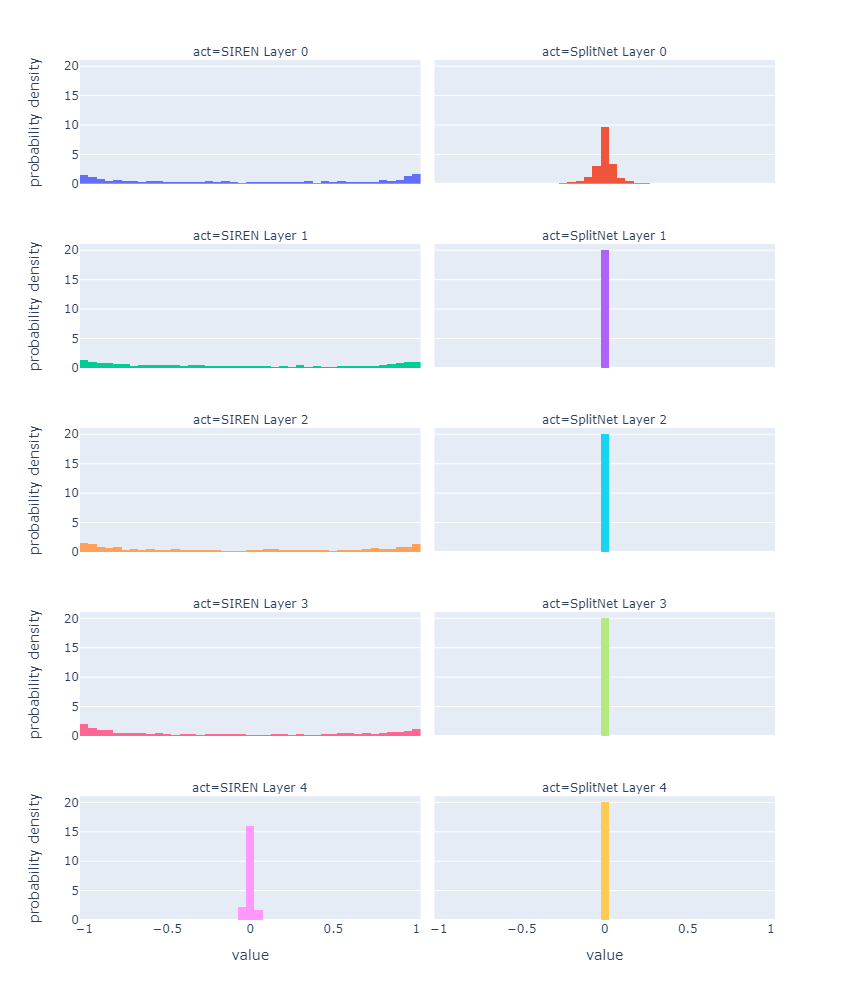

In [13]:
plot_distributions(datas, facet_col_wrap=2, autosize=False, width=1000, height=1000, title=None)

In [14]:
from spellbook.splitnet import *

In [15]:

def tensor2str(x):
    return f'{tuple(x.shape)} in [{x.min():.3f}, {x.max():.3f}] μ={x.mean():.3f} σ={x.std():.3f}'


In [16]:
def plot_distributions_custom(data, 
                       title='sample titles', 
                       autosize=False, 
                       facet_col_wrap=4,
                       width=1000,
                       height=600):
    for k, v in data.items():
        print(k, tensor2str(v))
    data = {k: to_np(v) for k, v in data.items()}

    df = pd.DataFrame(data)

    # Melt the dataframe to a long format for easier plotting
    df_melted = df.melt(var_name="act", value_name="value")

    # Plot histograms using Plotly Express
    fig = px.histogram(
        df_melted,
        x="value",
        color="act",
        facet_col="act",
        facet_col_wrap=facet_col_wrap,
        histnorm="probability density",
        title=title,
    )

    fig.update_layout(
        autosize=False,
        width=width,
        height=height,
        showlegend=False,
    )

    fig.show()

In [17]:
import plotly.subplots as sp
import plotly.graph_objects as go

def plot_distributions_custom(data, 
                       title='sample titles', 
                       autosize=False, 
                       width=1000,
                       height=600):
    data = {k: to_np(v) for k, v in data.items()}

    # Determine number of rows for the subplots
    n = len(data)
    rows = n // 4 + (n % 4 > 0)

    # Create a subplot with 'rows' number of rows and 4 columns
    fig = sp.make_subplots(rows=rows, cols=4, subplot_titles=list(data.keys()))

    for i, (k, v) in enumerate(data.items(), start=1):
        row = i // 4 + (i % 4 > 0)
        col = i % 4 if i % 4 != 0 else 4

        # Convert each item into a DataFrame
        df = pd.DataFrame({k: v})

        # Create a histogram
        hist = go.Histogram(
            x=df[k],
            histnorm="probability density",
            name=k
        )

        # Add histogram to the subplot
        fig.add_trace(hist, row=row, col=col)
        
    fig.update_layout(
        autosize=autosize,
        width=width,
        height=height * rows,
        showlegend=False,
        title_text=title,
    )
    
    fig.show()


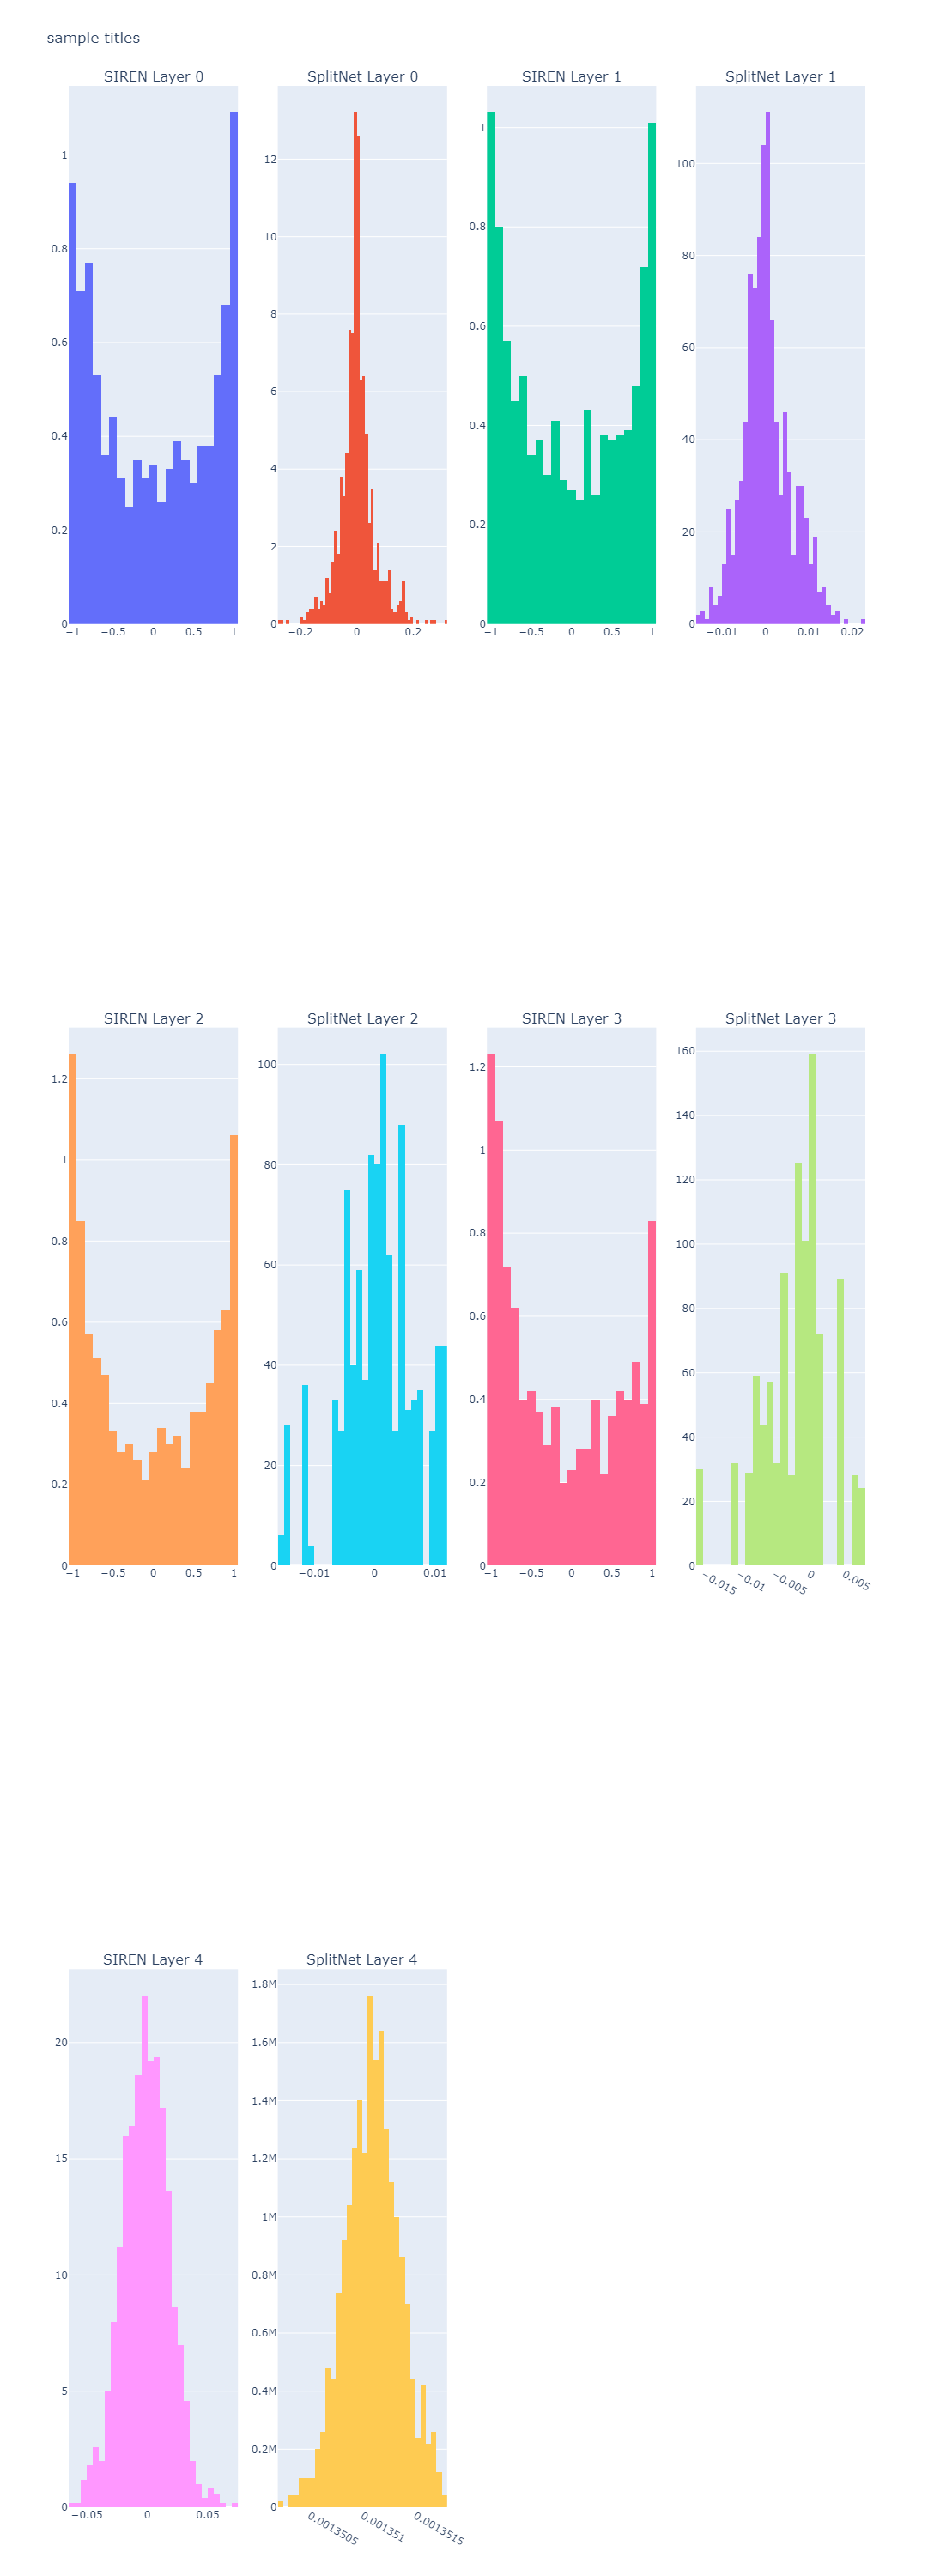

In [18]:
plot_distributions_custom(datas, autosize=False, width=1000, height=1000)

# LSUV

In [3]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import lovely_tensors as lt
lt.monkey_patch()

# Orthonorm init code is taked from Lasagne
# https://github.com/Lasagne/Lasagne/blob/master/lasagne/init.py
def svd_orthonormal(w):
    shape = w.shape
    if len(shape) < 2:
        raise RuntimeError("Only shapes of length 2 or more are supported.")
    flat_shape = (shape[0], np.prod(shape[1:]))
    a = np.random.normal(0.0, 1.0, flat_shape)#w;
    u, _, v = np.linalg.svd(a, full_matrices=False)
    q = u if u.shape == flat_shape else v
    # print (shape, flat_shape)
    q = q.reshape(shape)
    return q.astype(np.float32)


def orthogonal_weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        if hasattr(m, 'weight'):
            w_ortho = svd_orthonormal(m.weight.data.cpu().numpy())
            m.weight.data = torch.from_numpy(w_ortho)
            try:
                nn.init.constant_(m.bias, 0)
            except:
                pass
        else:
            #nn.init.orthogonal(m.weight)
            w_ortho = svd_orthonormal(m.weight.data.cpu().numpy())
            #print w_ortho 
            #m.weight.data.copy_(torch.from_numpy(w_ortho))
            m.weight.data = torch.from_numpy(w_ortho)
            try:
                nn.init.constant_(m.bias, 0)
            except:
                pass
    return


def splitnet_lsuv_init(self, batch_x, multipliers=(1,1.,1.,1), verbose=True):
    device = batch_x.device
    self = self.apply(orthogonal_weights_init)
    self = self.to(device)

    batch_x = self.encoding(batch_x)

    net = self.networks[0].net

    h = batch_x
    for layer in net:
        out, acts = layer.forward_with_activations(h)

        if True:
            if verbose:
                print('*'*40)
                print('Working with layer', layer)
            x, preact, preact_tanh, preact_sigmoid, preact_sin, preact_cos, act_tanh, act_sigmoid, act_sin, act_cos = acts

            shape = layer.linear.weight.data.shape[0]//4
            # print(layer.linear.weight.data.shape)
            for i, preact in enumerate([preact_tanh, preact_sigmoid, preact_sin, preact_cos]):
                if verbose:
                    print('Initial preact:', preact)
                from_i, to_i = i*shape, (i+1)*shape
                # W = layer.linear.weight.data[]

                mean = preact.mean().item()
                std = preact.std().item()

                layer.linear.bias.data[from_i:to_i] -= mean
                layer.linear.weight.data[from_i:to_i] /= std

                layer.linear.weight.data[from_i:to_i] *= multipliers[i]
                # print('from_i:to_i', from_i, to_i)
                # out, acts = layer.forward_with_activations(h)
                # x, preact, preact_tanh, preact_sigmoid, preact_sin, preact_cos, act_tanh, act_sigmoid, act_sin, act_cos = acts

            out, acts = layer.forward_with_activations(h)
            x, preact, preact_tanh, preact_sigmoid, preact_sin, preact_cos, act_tanh, act_sigmoid, act_sin, act_cos = acts
            for i, preact in enumerate([preact_tanh, preact_sigmoid, preact_sin, preact_cos]):
                if verbose:
                    print('After   preact:', preact)


        h = out
        
    return self

In [10]:
multipliers = [1.407,
0.4125,
0.7868,
0.2076,]


m = 22

In [11]:
mult_suff = "mults=" + ",".join([str(m) for m in multipliers])
m_suff = f'm={m}'
mult_suff

'mults=1.407,0.4125,0.7868,0.2076'

****************************************
Working with layer SplitLayer(
  (linear): Linear(in_features=256, out_features=512, bias=True)
  (dropout): Dropout(p=0, inplace=False)
)
Initial preact: tensor[1, 65536, 128] n=8388608 x∈[-2.609, 2.624] μ=-1.287e-05 σ=0.498 grad MulBackward0
Initial preact: tensor[1, 65536, 128] n=8388608 x∈[-2.558, 2.575] μ=-0.000 σ=0.501 grad MulBackward0
Initial preact: tensor[1, 65536, 128] n=8388608 x∈[-2.455, 2.661] μ=0.000 σ=0.501 grad MulBackward0
Initial preact: tensor[1, 65536, 128] n=8388608 x∈[-2.530, 2.677] μ=-0.000 σ=0.501 grad MulBackward0
After   preact: tensor[1, 65536, 128] n=8388608 x∈[-7.374, 7.413] μ=-2.349e-05 σ=1.407 grad MulBackward0
After   preact: tensor[1, 65536, 128] n=8388608 x∈[-2.107, 2.122] μ=7.359e-05 σ=0.412 grad MulBackward0
After   preact: tensor[1, 65536, 128] n=8388608 x∈[-3.858, 4.181] μ=0.000 σ=0.787 grad MulBackward0
After   preact: tensor[1, 65536, 128] n=8388608 x∈[-1.049, 1.110] μ=0.000 σ=0.208 grad MulBackward0
****

********************************************************************************


image: cameraman
image_dir: ../../data
image_W: 256
use_wandb: true
is_debug: false
total_steps: 3000
random_seed:
- 0
model:
  _target_: spellbook.parallel.ParallelSplitNet
  model_configs:
  - hidden_layers:
    - 128
    - 128
    m:
    - 22
    - 1.0
logging:
  logger:
    _target_: spellbook.logging.wandb.WandbLogger
    project: 01_splitnet__${image}
  steps_till_summary: 500
  experiment_name: splitnet_m=22_mults=1.407,0.4125,0.7868,0.2076__lsuv
optimizer:
  _target_: torch.optim.AdamW
  weight_decay: 0.0
  lr: 0.0001
device: cuda:0


********************************************************************************
+--------------------------------+------------+
|            Modules             | Parameters |
+--------------------------------+------------+
| networks.0.net.0.linear.weight |   131072   |
|  networks.0.net.0.linear.bias  |    512     |
| networks.0.net.1.linear.weight |   65536    |

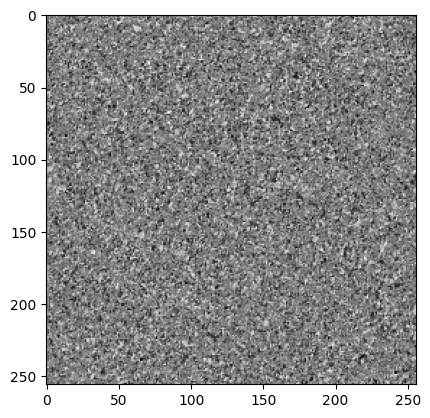

Step 500, Total loss 0.000982


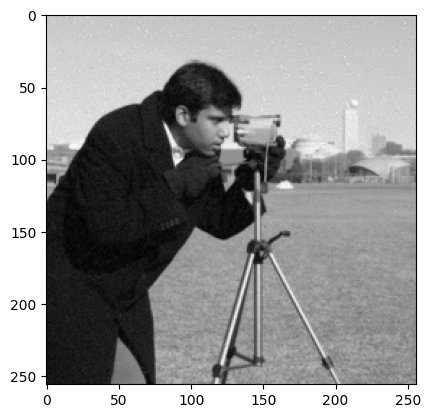

Step 1000, Total loss 0.000055


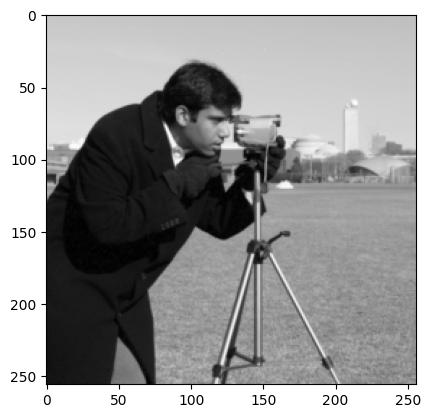

Step 1500, Total loss 0.000013


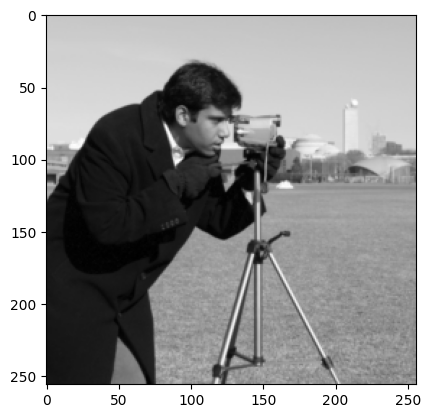

Step 2000, Total loss 0.000004


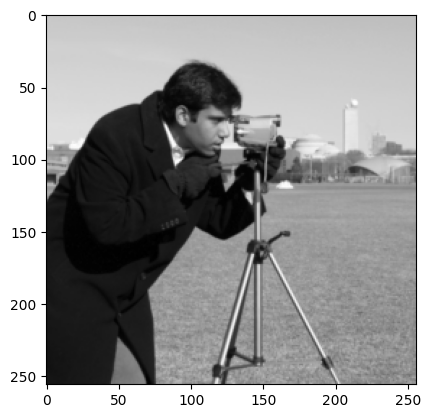

Step 2500, Total loss 0.000002


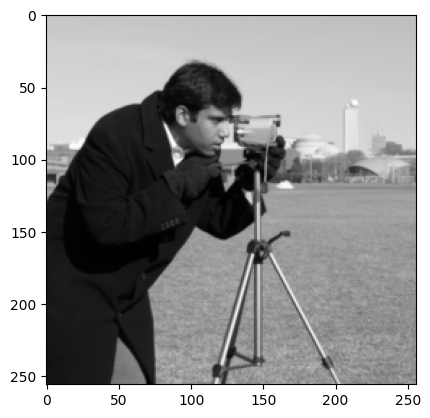

(ParallelSplitNet(
   (encoding): GaussianEncoding()
   (networks): ModuleList(
     (0): SimpleSplitNet(
       (net): Sequential(
         (0): SplitLayer(
           (linear): Linear(in_features=256, out_features=512, bias=True)
           (dropout): Dropout(p=0, inplace=False)
         )
         (1): SplitLayer(
           (linear): Linear(in_features=128, out_features=512, bias=True)
           (dropout): Dropout(p=0, inplace=False)
         )
         (2): SplitLayer(
           (linear): Linear(in_features=128, out_features=4, bias=True)
           (dropout): Dropout(p=0, inplace=False)
         )
       )
     )
   )
 ),
 tensor grad MulBackward0 cuda:0 60.963)

In [12]:
from train_pipeline import train, load_data, _train_seed

import os
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from hydra.utils import instantiate
from omegaconf import OmegaConf


def load_cfg(overrides=(), config_name='config'):
    # with initialize_config_dir(config_dir="/app/notebooks/draft_02/conf"):
    with initialize(version_base=None, config_path="./conf"):
        cfg = compose(config_name=config_name, overrides=list(overrides))
        return cfg

from IPython.display import clear_output

cfg = load_cfg(config_name='08_splitnet_first_step')

cfg.logging.experiment_name=f'splitnet_{m_suff}_{mult_suff}__lsuv'
cfg.model.model_configs[0]['m'] = [m]*(len(cfg.model.model_configs[0]['hidden_layers']) - 1) + [1.]
# print(OmegaConf.to_yaml(cfg))

splitnet_m10 = instantiate(cfg.model, out_features=1)
model_input, ground_truth, H, W = load_data(cfg)
splitnet_lsuv_init(splitnet_m10, model_input, multipliers=multipliers)

_train_seed(cfg, model=splitnet_m10)

# Add m

image: cameraman
image_dir: ../../data
image_W: 512
use_wandb: true
is_debug: false
total_steps: 3000
random_seed:
- 0
model:
  _target_: spellbook.parallel.ParallelSplitNet
  model_configs:
  - hidden_layers:
    - 32
    - 32
    - 32
    - 32
    m: 1.0
logging:
  logger:
    _target_: spellbook.logging.wandb.WandbLogger
    project: 01_splitnet__${image}
  steps_till_summary: 500
  experiment_name: splitnet_posenc__baseline
optimizer:
  _target_: torch.optim.AdamW
  weight_decay: 0.0
  lr: 0.0001
device: cuda:1

+--------------------------------+------------+
|            Modules             | Parameters |
+--------------------------------+------------+
| networks.0.net.0.linear.weight |   32768    |
|  networks.0.net.0.linear.bias  |    128     |
| networks.0.net.1.linear.weight |    4096    |
|  networks.0.net.1.linear.bias  |    128     |
| networks.0.net.2.linear.weight |    4096    |
|  networks.0.net.2.linear.bias  |    128     |
| networks.0.net.3.linear.weight |    4096    

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kilianovski. Use `wandb login --relogin` to force relogin


********************************************************************************


image: cameraman
image_dir: ../../data
image_W: 512
use_wandb: true
is_debug: false
total_steps: 3000
random_seed:
- 0
model:
  _target_: spellbook.parallel.ParallelSplitNet
  model_configs:
  - hidden_layers:
    - 32
    - 32
    - 32
    - 32
    m: 10.0
logging:
  logger:
    _target_: spellbook.logging.wandb.WandbLogger
    project: 01_splitnet__${image}
  steps_till_summary: 500
  experiment_name: splitnet_posenc__m10_full
optimizer:
  _target_: torch.optim.AdamW
  weight_decay: 0.0
  lr: 0.0001
device: cuda:1


********************************************************************************


/opt/conda/lib/python3.7/site-packages/torch/functional.py:504: UserWarning:

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)



+--------------------------------+------------+
|            Modules             | Parameters |
+--------------------------------+------------+
| networks.0.net.0.linear.weight |   32768    |
|  networks.0.net.0.linear.bias  |    128     |
| networks.0.net.1.linear.weight |    4096    |
|  networks.0.net.1.linear.bias  |    128     |
| networks.0.net.2.linear.weight |    4096    |
|  networks.0.net.2.linear.bias  |    128     |
| networks.0.net.3.linear.weight |    4096    |
|  networks.0.net.3.linear.bias  |    128     |
| networks.0.net.4.linear.weight |    128     |
|  networks.0.net.4.linear.bias  |     4      |
+--------------------------------+------------+
Total Trainable Params: 45700
Step 0, Total loss 0.489767


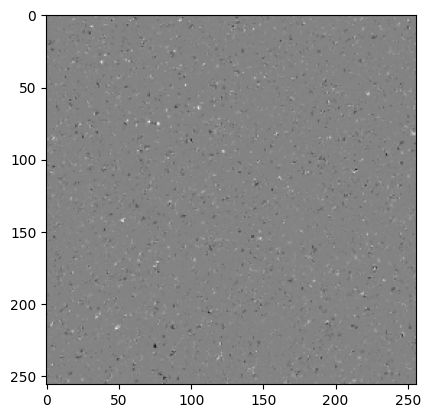

Step 500, Total loss 0.114243


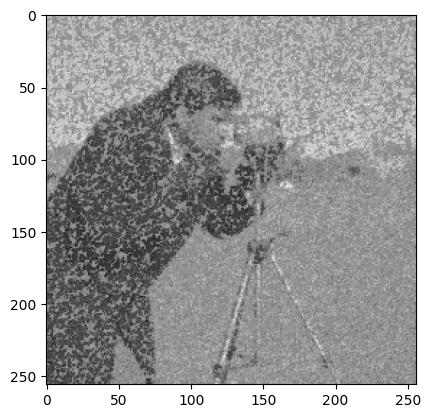

Step 1000, Total loss 0.045229


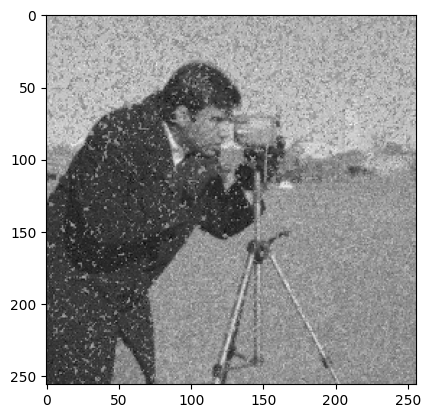

Step 1500, Total loss 0.027302


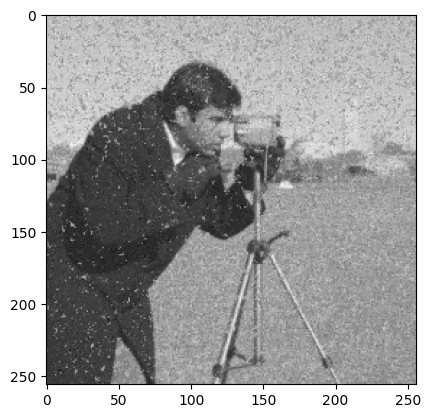

Step 2000, Total loss 0.020811


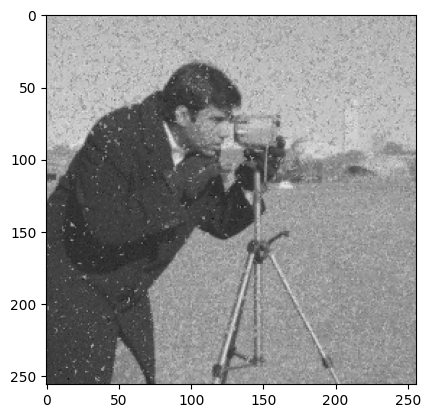

Step 2500, Total loss 0.017512


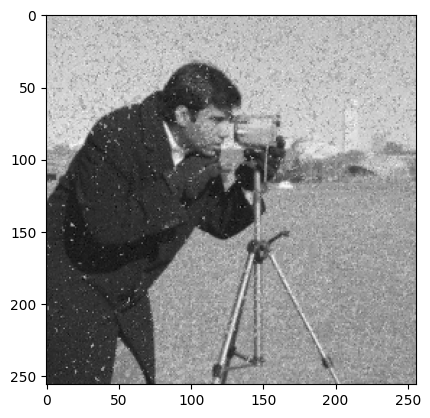

In [25]:
cfg = load_cfg(overrides=[
    "+exp=01_splitnet_posenc",
    "random_seed=[0]",
    "image=cameraman",
    "+device=cuda:1",
])

print(OmegaConf.to_yaml(cfg))

cfg.model.model_configs = [{'hidden_layers': [32, 32, 32, 32], 'm': 10.0}]
cfg.logging.experiment_name = 'splitnet_posenc__m10_full'

splitnet = instantiate(cfg.model, out_features=1)
total_params = count_parameters(splitnet)

train(cfg)

image: cameraman
image_dir: ../../data
image_W: 512
use_wandb: true
is_debug: false
total_steps: 3000
random_seed:
- 0
model:
  _target_: spellbook.parallel.ParallelSplitNet
  model_configs:
  - hidden_layers:
    - 32
    - 32
    - 32
    - 32
    m: 1.0
logging:
  logger:
    _target_: spellbook.logging.wandb.WandbLogger
    project: 01_splitnet__${image}
  steps_till_summary: 500
  experiment_name: splitnet_posenc__baseline
optimizer:
  _target_: torch.optim.AdamW
  weight_decay: 0.0
  lr: 0.0001
device: cuda:1

+--------------------------------+------------+
|            Modules             | Parameters |
+--------------------------------+------------+
| networks.0.net.0.linear.weight |   32768    |
|  networks.0.net.0.linear.bias  |    128     |
| networks.0.net.1.linear.weight |    4096    |
|  networks.0.net.1.linear.bias  |    128     |
| networks.0.net.2.linear.weight |    4096    |
|  networks.0.net.2.linear.bias  |    128     |
| networks.0.net.3.linear.weight |    4096    

********************************************************************************


image: cameraman
image_dir: ../../data
image_W: 512
use_wandb: true
is_debug: false
total_steps: 3000
random_seed:
- 0
model:
  _target_: spellbook.parallel.ParallelSplitNet
  model_configs:
  - hidden_layers:
    - 32
    - 32
    - 32
    - 32
    m:
    - 10.0
    - 10
    - 10
    - 10
    - 1
logging:
  logger:
    _target_: spellbook.logging.wandb.WandbLogger
    project: 01_splitnet__${image}
  steps_till_summary: 500
  experiment_name: splitnet_posenc__m10
optimizer:
  _target_: torch.optim.AdamW
  weight_decay: 0.0
  lr: 0.0001
device: cuda:1


********************************************************************************
+--------------------------------+------------+
|            Modules             | Parameters |
+--------------------------------+------------+
| networks.0.net.0.linear.weight |   32768    |
|  networks.0.net.0.linear.bias  |    128     |
| networks.0.net.1.linear.weight |  

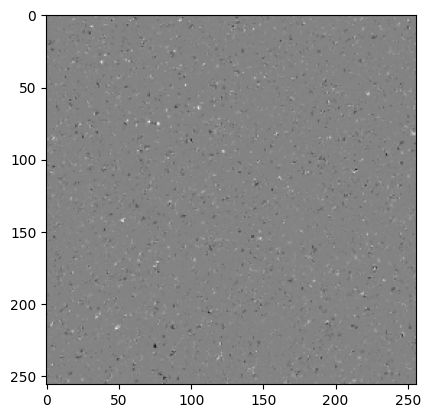

Step 500, Total loss 0.037965


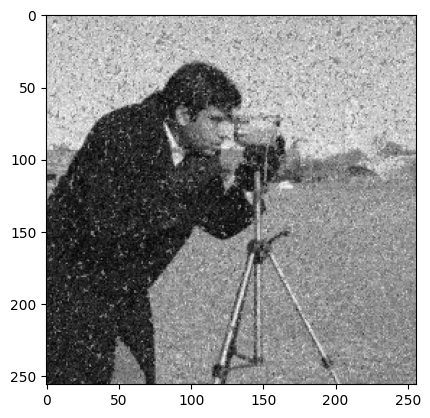

Step 1000, Total loss 0.014798


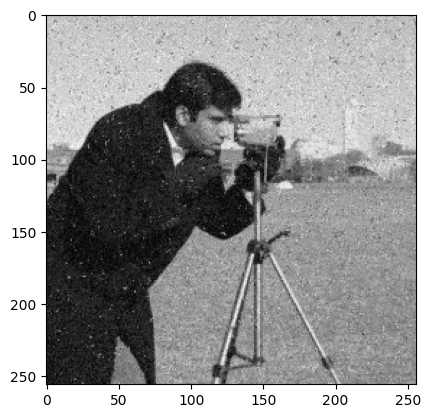

Step 1500, Total loss 0.009794


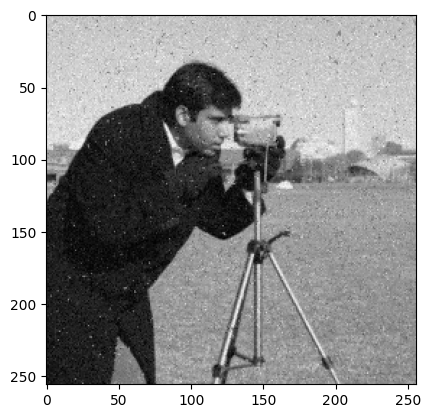

Step 2000, Total loss 0.007658


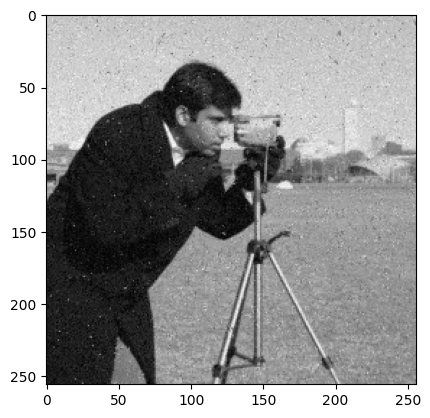

Step 2500, Total loss 0.006524


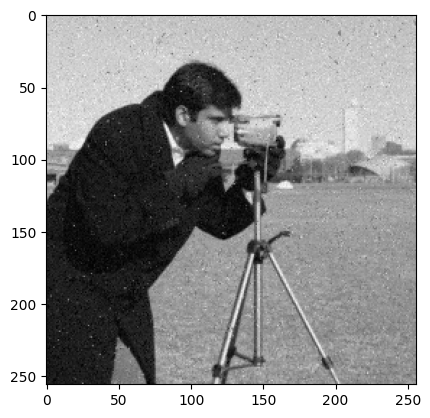

In [26]:
cfg = load_cfg(overrides=[
    "+exp=01_splitnet_posenc",
    "random_seed=[0]",
    "image=cameraman",
    "+device=cuda:1",
])

print(OmegaConf.to_yaml(cfg))

cfg.model.model_configs = [{'hidden_layers': [32, 32, 32, 32], 'm': [10.0, 10, 10, 10, 1]}]
cfg.logging.experiment_name = 'splitnet_posenc__m10'

splitnet = instantiate(cfg.model, out_features=1)
total_params = count_parameters(splitnet)

train(cfg)

# Tunned init

In [70]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import lovely_tensors as lt
lt.monkey_patch()

# Orthonorm init code is taked from Lasagne
# https://github.com/Lasagne/Lasagne/blob/master/lasagne/init.py
def svd_orthonormal(w):
    shape = w.shape
    if len(shape) < 2:
        raise RuntimeError("Only shapes of length 2 or more are supported.")
    flat_shape = (shape[0], np.prod(shape[1:]))
    a = np.random.normal(0.0, 1.0, flat_shape)#w;
    u, _, v = np.linalg.svd(a, full_matrices=False)
    q = u if u.shape == flat_shape else v
    # print (shape, flat_shape)
    q = q.reshape(shape)
    return q.astype(np.float32)


def orthogonal_weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        if hasattr(m, 'weight'):
            w_ortho = svd_orthonormal(m.weight.data.cpu().numpy())
            m.weight.data = torch.from_numpy(w_ortho)
            try:
                nn.init.constant_(m.bias, 0)
            except:
                pass
        else:
            #nn.init.orthogonal(m.weight)
            w_ortho = svd_orthonormal(m.weight.data.cpu().numpy())
            #print w_ortho 
            #m.weight.data.copy_(torch.from_numpy(w_ortho))
            m.weight.data = torch.from_numpy(w_ortho)
            try:
                nn.init.constant_(m.bias, 0)
            except:
                pass
    return


def splitnet_lsuv_init(self, batch_x, multipliers=(1,1.,1.,1), verbose=True):
    device = batch_x.device
    self = self.apply(orthogonal_weights_init)
    self = self.to(device)

    batch_x = self.encoding(batch_x)

    net = self.networks[0].net

    h = batch_x
    for layer in net:
        out, acts = layer.forward_with_activations(h)

        if True:
            if verbose:
                print('*'*40)
                print('Working with layer', layer)
            x, preact, preact_tanh, preact_sigmoid, preact_sin, preact_cos, act_tanh, act_sigmoid, act_sin, act_cos = acts

            shape = layer.linear.weight.data.shape[0]//4
            # print(layer.linear.weight.data.shape)
            for i, preact in enumerate([preact_tanh, preact_sigmoid, preact_sin, preact_cos]):
                if verbose:
                    print('Initial preact:', preact)
                from_i, to_i = i*shape, (i+1)*shape
                # W = layer.linear.weight.data[]

                mean = preact.mean().item()
                std = preact.std().item()

                layer.linear.bias.data[from_i:to_i] -= mean
                layer.linear.weight.data[from_i:to_i] /= std

                layer.linear.weight.data[from_i:to_i] *= multipliers[i]
                # print('from_i:to_i', from_i, to_i)
                # out, acts = layer.forward_with_activations(h)
                # x, preact, preact_tanh, preact_sigmoid, preact_sin, preact_cos, act_tanh, act_sigmoid, act_sin, act_cos = acts

            out, acts = layer.forward_with_activations(h)
            x, preact, preact_tanh, preact_sigmoid, preact_sin, preact_cos, act_tanh, act_sigmoid, act_sin, act_cos = acts
            for i, preact in enumerate([preact_tanh, preact_sigmoid, preact_sin, preact_cos]):
                if verbose:
                    print('After   preact:', preact)


        h = out
        
    return self

In [71]:
import wandb

In [72]:
def _custom_train_seed(model, cfg, random_seed=0):
    seed_all(random_seed)
    print("Setting seed to", random_seed)

    logger = instantiate(
        cfg.logging.logger,
        project=cfg.logging.logger.project,
        group=cfg.logging.experiment_name,
        name=f"rs{random_seed}",
    )
    print("*" * 80)
    print("\n")
    print(OmegaConf.to_yaml(cfg))
    print()
    print("*" * 80)

    device = cfg["device"]

    total_steps = cfg["total_steps"]
    steps_til_summary = cfg.logging["steps_till_summary"]
    batch_size = cfg.get('batch_size', None)

    best_psnr = 0
    optimizer = instantiate(cfg.optimizer, params=model.parameters())

    for step in range(total_steps):
        if batch_size:
            idxs = torch.randint(0, model_input.shape[1], (batch_size,))
            model_input_batch = model_input[:, idxs]
            ground_truth_batch = ground_truth[:, idxs]
        else:
            model_input_batch = model_input
            ground_truth_batch = ground_truth

        model_output_batch = model(model_input_batch)
        mse, psnr = mse_and_psnr(model_output_batch, ground_truth_batch)
        loss = mse

        psnr = psnr

        if best_psnr < psnr:
            best_psnr = psnr
        log_dic = {"step": step, "mse": mse.item(), "psnr": psnr.item()}
        logger.log_dict(log_dic)
        wandb.log(log_dic)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print(step)

    return model, best_psnr


In [73]:
# global
cfg = load_cfg(overrides=[
    "+exp=07_splitnet_lsuv",
    "random_seed=[0]",
    'logging.logger._target_=spellbook.logging.wandb.WandbLogger',
    # "model.model_configs=[{'hidden_layers': [32, 32]}]",
    "image=cameraman",
    'logging.logger.init_on_creation=true',
    "+device=cuda:0",
])

device = cfg["device"]

model_input, ground_truth, H, W = load_data(cfg)
model_input, ground_truth = model_input.to(device), ground_truth.to(device)

In [74]:
cfg.logging

{'logger': {'_target_': 'spellbook.logging.wandb.WandbLogger', 'project': '01_splitnet__${image}', 'init_on_creation': True}, 'steps_till_summary': 500, 'experiment_name': 'splitnet_lsuv_sweep'}

In [75]:
splitnet = instantiate(cfg.model, out_features=1)
total_params = count_parameters(splitnet)

+--------------------------------+------------+
|            Modules             | Parameters |
+--------------------------------+------------+
| networks.0.net.0.linear.weight |   32768    |
|  networks.0.net.0.linear.bias  |    128     |
| networks.0.net.1.linear.weight |    4096    |
|  networks.0.net.1.linear.bias  |    128     |
| networks.0.net.2.linear.weight |    128     |
|  networks.0.net.2.linear.bias  |     4      |
+--------------------------------+------------+
Total Trainable Params: 37252


In [76]:
lsuv_multipliers = (3, 4.4, 8.65, 0.28)
m = 90

In [78]:
out_features = ground_truth.shape[-1]


cfg.model.model_configs[0]['hidden_layers'] = [32] * 5
cfg.model.model_configs[0]['m'] = [m]*(len(cfg.model.model_configs[0]['m']) - 1) + [1.]
cfg.total_steps = 3000
cfg.logging.experiment_name = 'splitnet_lsuv_sweep__small'
print(OmegaConf.to_yaml(cfg))

model = instantiate(cfg["model"], out_features=out_features)
model.to(device)

model = splitnet_lsuv_init(model, model_input, multipliers=lsuv_multipliers, verbose=False)
model, best_psnr = _custom_train_seed(model, cfg, random_seed=cfg.random_seed[0])

print('best_psnr', best_psnr)
wandb.log({'last_psnr': best_psnr})

image: cameraman
image_dir: ../../data
image_W: 512
use_wandb: true
is_debug: false
total_steps: 3000
random_seed:
- 0
model:
  _target_: spellbook.parallel.ParallelSplitNet
  model_configs:
  - hidden_layers:
    - 32
    - 32
    m:
    - 90
    - 90
    - 1.0
logging:
  logger:
    _target_: spellbook.logging.wandb.WandbLogger
    project: 01_splitnet__${image}
    init_on_creation: true
  steps_till_summary: 500
  experiment_name: splitnet_lsuv_sweep__small
optimizer:
  _target_: torch.optim.AdamW
  weight_decay: 0.0
  lr: 0.0001
device: cuda:0

Setting seed to 0


********************************************************************************


image: cameraman
image_dir: ../../data
image_W: 512
use_wandb: true
is_debug: false
total_steps: 3000
random_seed:
- 0
model:
  _target_: spellbook.parallel.ParallelSplitNet
  model_configs:
  - hidden_layers:
    - 32
    - 32
    m:
    - 90
    - 90
    - 1.0
logging:
  logger:
    _target_: spellbook.logging.wandb.WandbLogger
    project: 01_splitnet__${image}
    init_on_creation: true
  steps_till_summary: 500
  experiment_name: splitnet_lsuv_sweep__small
optimizer:
  _target_: torch.optim.AdamW
  weight_decay: 0.0
  lr: 0.0001
device: cuda:0


********************************************************************************
best_psnr tensor grad MulBackward0 cuda:0 12.191
